### [Autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html)

![alt-text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Visualization

In [37]:
def plot_figures(original, decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [5]:
def plot_encoded(encoded):
    plt.figure(figsize=(7, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

### Simple autoencoder based on a fully-connected layer

In [6]:
# this is the size of our encoded representations
encoding_dim = 32
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

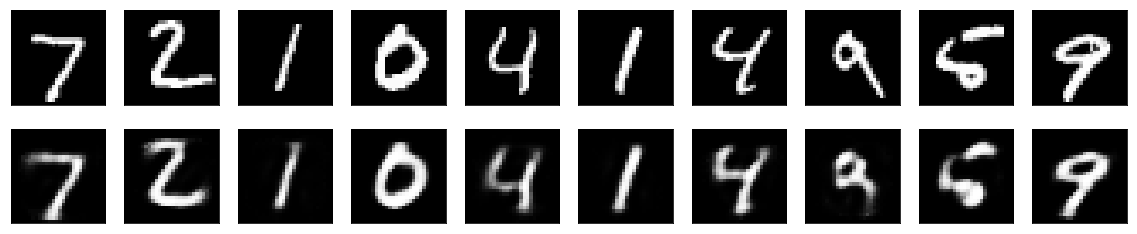

In [9]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

### Sparse autoencoder

In [10]:
encoding_dim = 32
input_img = Input(shape=(784,))

# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-9))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [11]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

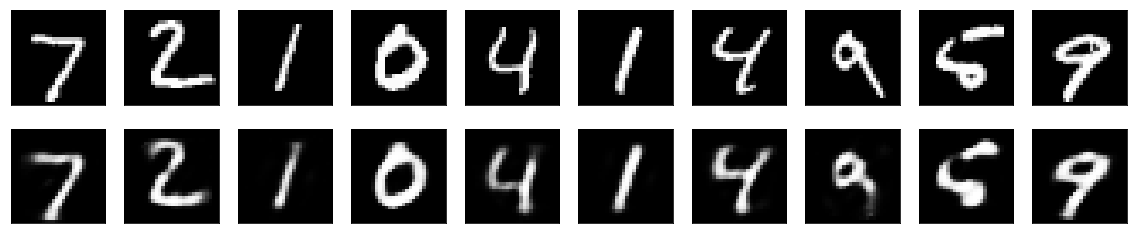

In [13]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

### Deep autoencoder

In [14]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [15]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

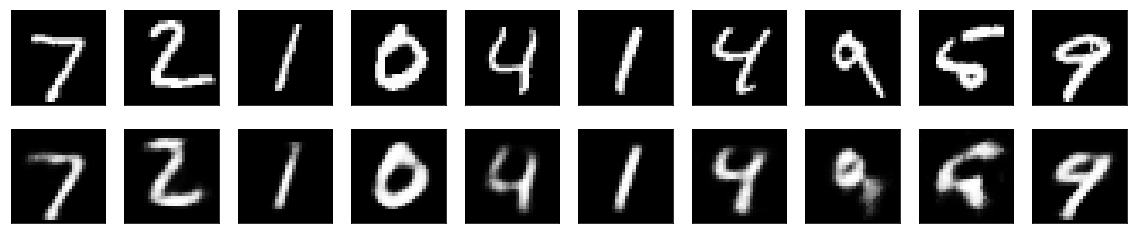

In [17]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

### Convolutional autoencoder

In [19]:
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [20]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [22]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

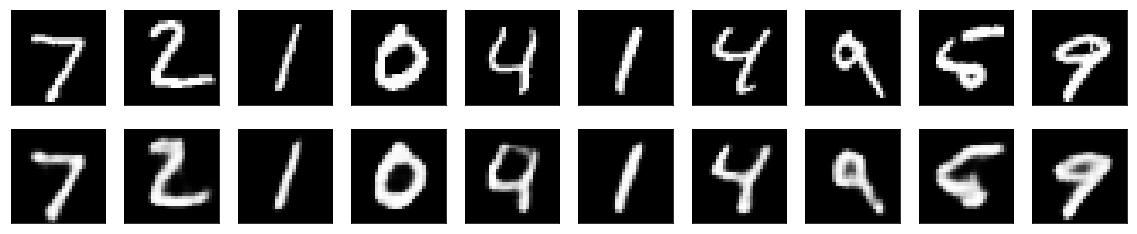

In [25]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

### Image denoising

In [26]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [27]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [28]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [33]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=0)

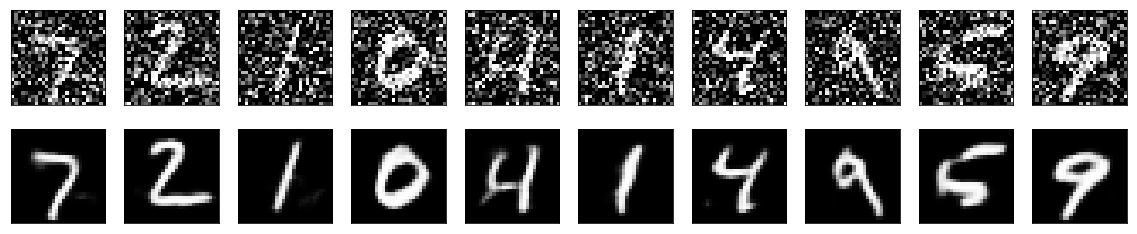

In [38]:
decoded_imgs = autoencoder.predict(x_test_noisy)
plot_figures(x_test_noisy, decoded_imgs)